In [8]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np

## 確認裝置

In [9]:
# 1. 裝置設定
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"使用裝置：{device}")

使用裝置：cpu


## 下載資料集

In [10]:
# 2. 資料前處理與載入
transform = transforms.Compose([
    transforms.ToTensor(),  # 直接將像素從 [0,255] => [0,1]
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=128, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [11]:
class CNN2(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        #act = nn.ReLU()  # ✔ 可改 nn.GELU()、nn.SiLU() 等，常對收斂有幫助（非深/寬，但可提升表現）
        #act = nn.GELU()
        #act = nn.SiLU()

        # ====== 深度：在每個 block 內多加 Conv-BN-Act 可「變深」
        # ====== 寬度：把 out_channels（64/128）調大可「變寬」（例如 96/192、128/256）
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, padding=1,bias=False),   # 寬度：這裡的 64 ↑ 可變寬
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # 深度：你可以在這裡再插一層 Conv-BN-Act 增加深度
            # nn.Conv2d(64, 64, 3, padding=1); nn.BatchNorm2d(64); act,
            nn.MaxPool2d(2, 2)    # 空間 32→16；如要更多 block，要注意空間不要被池化到太小
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1,bias=False), # 寬度：128 ↑ 可變寬
            nn.BatchNorm2d(256),
            nn.ReLU(),  # 深度：同理可再插一層 Conv-BN-Act
            nn.MaxPool2d(2, 2)           # 16→8
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1,bias=False), # 寬度：128 ↑ 可變寬
            nn.BatchNorm2d(512),
            nn.ReLU(),  # 深度：同理可再插一層 Conv-BN-Act
            nn.MaxPool2d(2, 2)           # 16→8
        )

        self.gap = nn.AdaptiveAvgPool2d(1)  # 8x8 -> 1x1
        self.fc1 = nn.Linear(512, num_classes)
          # 若把上面「寬度」改大，fc 的 in_features 也要跟著改
          #self.fc1 = nn.Linear(64, num_classes)  # ← 舊（會錯，因為上一層是 128 channels）
        #self.fc1 = nn.Linear(128, num_classes) # ✔ 這裡需對應最後一個 block 的 out_channels

    def forward(self, x):
        x = self.block1(x)   # (B,64,16,16) ← 若你把「寬度」調大，這裡 channel 也會變
        x = self.block2(x)   # (B,128,8,8)
        x = self.block3(x)
        x = self.gap(x)      # (B,128,1,1)
        x = x.view(x.size(0), -1)  # (B,256)
        #x = self.fc1(x)      # (B,num_classes)
        return self.fc1(x)
    
model2 = CNN2().to(device)
print(model2)

# 4. 損失與優化器
criterion = nn.CrossEntropyLoss()  # 直接接收整數標籤
optimizer = optim.Adam(model2.parameters(), lr=0.001,weight_decay=5e-4)


CNN2(
  (block1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (gap): AdaptiveAvgPool2d(output_size=1)
  (fc1): Linear(in_features=512, 

In [12]:
best_acc, best_state = 0.0, None
patience= 8
bad = 0   # 早停耐心：8 個 epoch 沒進步就停

num_epochs = 50

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(1, num_epochs + 1):
    # ====== 訓練 ======
    model2.train()
    running_loss = 0.0
    correct, total = 0, 0

    for imgs, labels in trainloader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model2(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        _, preds = outputs.max(1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

    epoch_loss = running_loss / len(trainloader.dataset)
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # ====== 驗證 ======
    model2.eval()
    val_running_loss = 0.0
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for imgs, labels in testloader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model2(imgs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * imgs.size(0)
            _, preds = outputs.max(1)
            val_total += labels.size(0)
            val_correct += (preds == labels).sum().item()

    val_loss = val_running_loss / len(testloader.dataset)
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch}/{num_epochs} — "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f} — "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    #存最好、早停
    if val_acc > best_acc:
        best_acc= val_acc
        bad = 0
        best_state = {k: v.cpu() for k, v in model2.state_dict().items()}
    else:
        bad += 1
        if bad >= patience:
            print(f"Early stop at epoch {epoch}. Best Val Acc={best_acc:.4f}")
            break

    #3) 在第 8 或 10 回合後降學習率 ×0.1（擇一）
    if epoch == 20:  # 或改成 10、或多次在 8/12/16 都降
        for g in optimizer.param_groups:
            g['lr'] *= 0.1
        print(f"→ 降 LR，現在 lr={optimizer.param_groups[0]['lr']:.2e}")

# 訓練結束：還原最佳權重
if best_state is not None:
    model2.load_state_dict(best_state)
    print(f"Loaded best checkpoint with Val Acc={best_acc:.4f}")

Epoch 1/50 — Train Loss: 1.3290, Train Acc: 0.5228 — Val Loss: 1.4862, Val Acc: 0.4763


KeyboardInterrupt: 

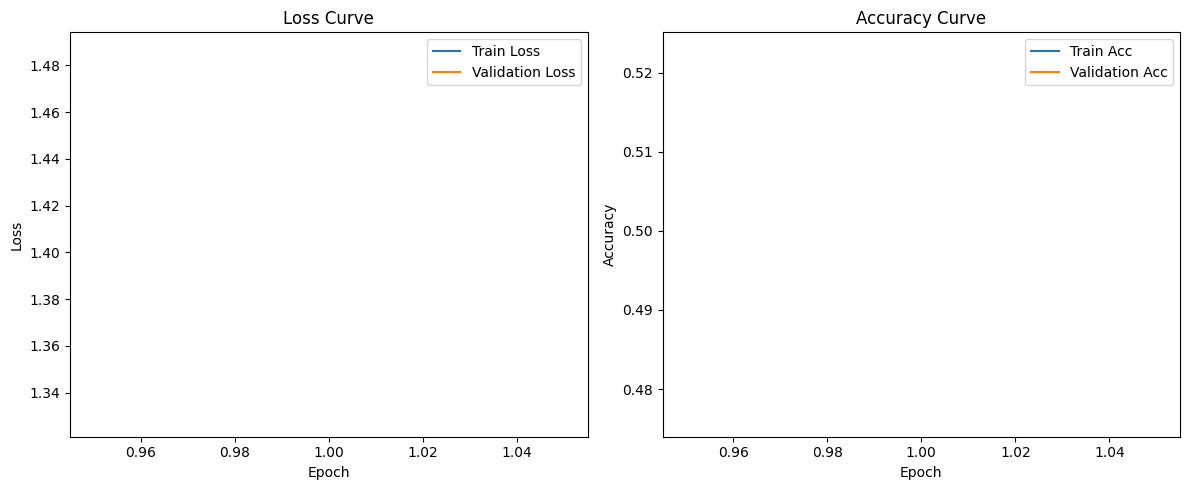

[debug] lengths → train_losses=1, val_losses=1, train_acc=1, val_acc=1


In [13]:
# ====== 畫 Accuracy 曲線 ======
# 依「實際跑完的回合數」畫
# 安全地用最短長度對齊
n = min(len(train_losses), len(val_losses), len(train_accuracies), len(val_accuracies))
if n == 0:
    raise ValueError("沒有可畫的資料：請確認已經把每個 epoch 的 loss/acc append 進四個 list。")

xs = np.arange(1, n + 1)

plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(xs, np.array(train_losses[:n]), label='Train Loss')
plt.plot(xs, np.array(val_losses[:n]),   label='Validation Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss Curve'); plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(xs, np.array(train_accuracies[:n]), label='Train Acc')
plt.plot(xs, np.array(val_accuracies[:n]),   label='Validation Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy Curve'); plt.legend()

plt.tight_layout()
plt.show()

print(f"[debug] lengths → train_losses={len(train_losses)}, val_losses={len(val_losses)}, "
      f"train_acc={len(train_accuracies)}, val_acc={len(val_accuracies)}")
